In [1]:
import fiftyone as fo
import os
from tqdm import tqdm
from fiftyone import ViewField as F
import torch
import clip
import fiftyone.brain as fob

/home/andre/miniconda3/envs/ml/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
def get_images(dir):
    folder_path = 'dataset/train'
    image_paths = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff', '.webp')):
                image_paths.append(os.path.join(root, file))
    return image_paths


In [5]:
dataset = fo.Dataset(name='Felines', persistent=True)
# dataset = fo.load_dataset('Felines')

In [10]:
train_images = get_images('dataset/train')
test_images = get_images('dataset/test')

In [ ]:
dataset.add_images(train_images)
dataset.add_images(test_images)

In [14]:
for sample in tqdm(dataset):
    sample['original_filepath'] = sample.filepath
    sample.save()

100%|██████████| 6143/6143 [00:02<00:00, 2284.25it/s]


In [17]:
for label in ['guepard', 'jaguar', 'leopard', 'tigre']:

    for sample in tqdm(dataset.match(F('original_filepath').contains_str(label))):

        sample['class'] = fo.Classification(label = label)
        sample.save()

100%|██████████| 1541/1541 [00:01<00:00, 1347.79it/s]


In [19]:
from app.embed import encode_image

In [22]:
device = "cuda" if torch.cuda.is_available() else "cpu"
encoder = clip.load("ViT-B/32", device=device)

In [23]:
for sample in tqdm(dataset):
    sample['embeddings'] = encode_image(sample.filepath, encoder)
    sample.save()

100%|██████████| 6143/6143 [00:48<00:00, 126.12it/s]


In [26]:
embeddings = {sample.id : sample.embeddings for sample in tqdm(dataset)}

100%|██████████| 6143/6143 [00:01<00:00, 3809.73it/s]


In [32]:
embeddings = {sample.id : sample.embeddings for sample in tqdm(dataset)}
results = fob.compute_visualization(
    dataset,
    method="umap",
    embeddings=embeddings,
    brain_key="img_viz"
)

Generating visualization...


/home/andre/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


UMAP( verbose=True)
Mon Jun 23 22:11:36 2025 Construct fuzzy simplicial set
Mon Jun 23 22:11:36 2025 Finding Nearest Neighbors
Mon Jun 23 22:11:36 2025 Building RP forest with 9 trees
Mon Jun 23 22:11:39 2025 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	 4  /  13
	Stopping threshold met -- exiting after 4 iterations
Mon Jun 23 22:11:46 2025 Finished Nearest Neighbor Search
Mon Jun 23 22:11:47 2025 Construct embedding


Epochs completed:  30%| ██▉        148/500 [00:01]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs


Epochs completed:  41%| ████       206/500 [00:01]

	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs


Epochs completed:  87%| ████████▋  435/500 [00:01]

	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs


Epochs completed: 100%| ██████████ 500/500 [00:01]


Mon Jun 23 22:11:49 2025 Finished embedding



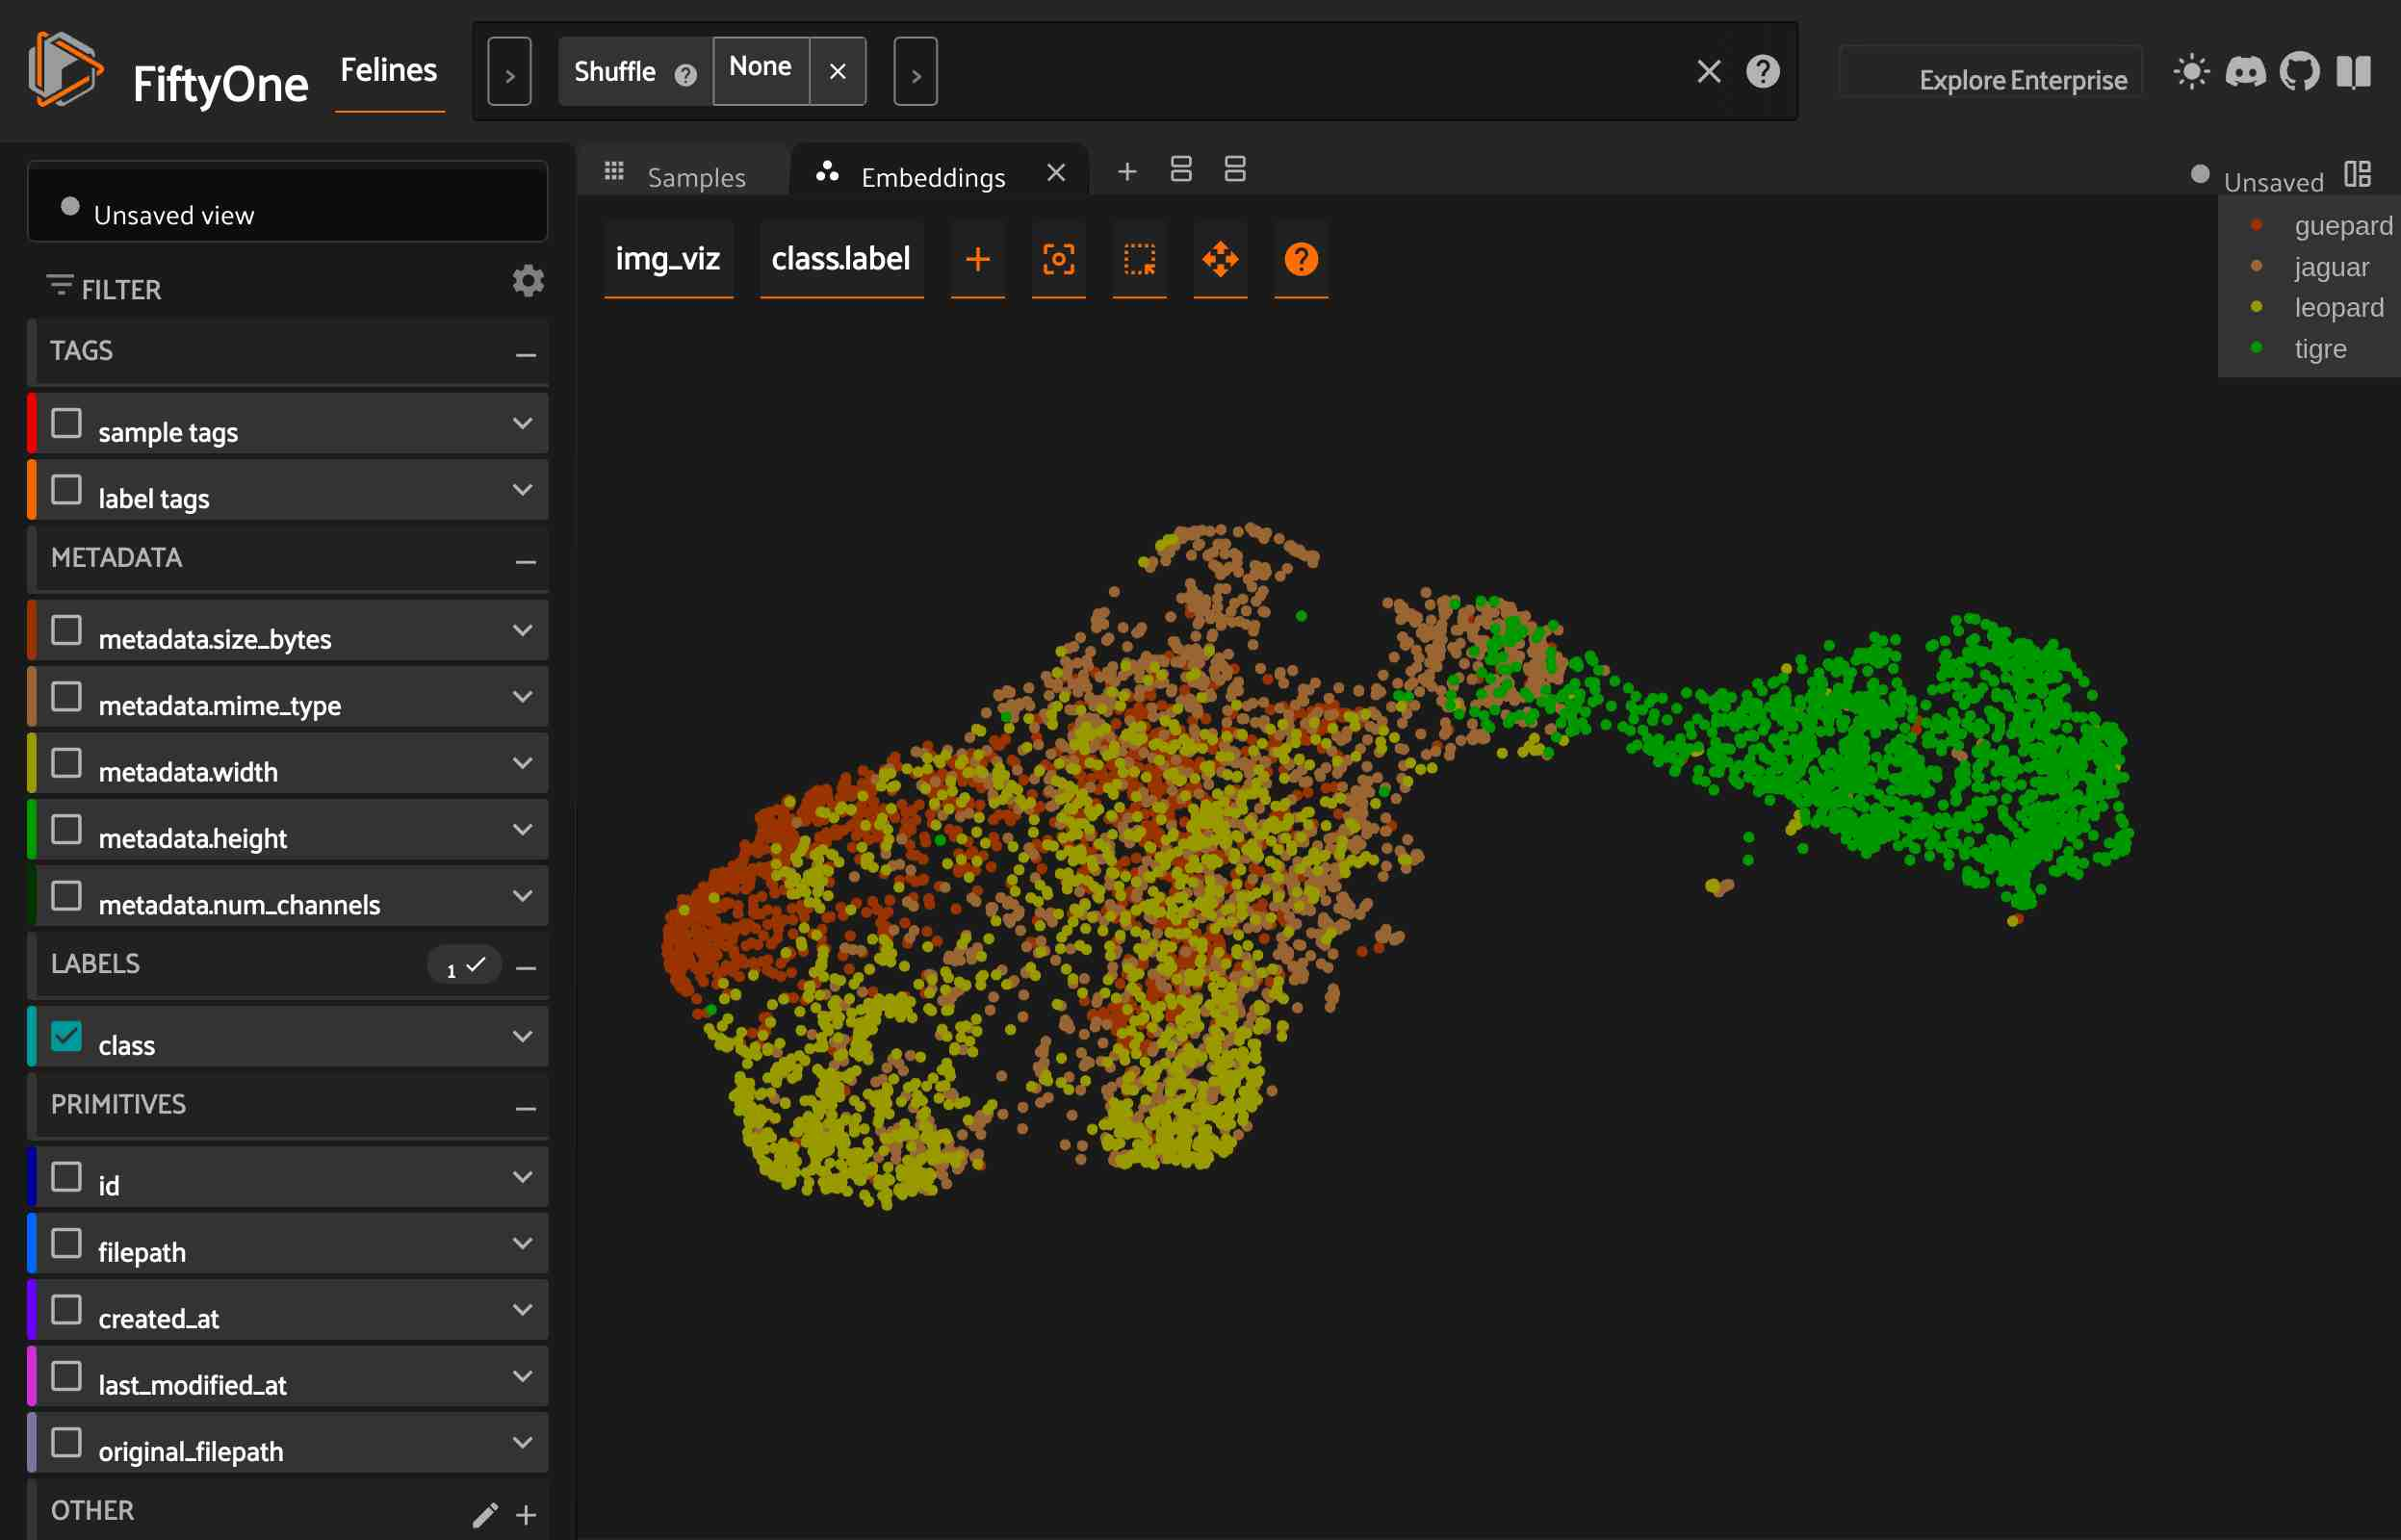

In [35]:
session = fo.launch_app()

In [36]:
fob.compute_similarity(
    dataset,
    model="clip-vit-base32-torch",
    brain_key="img_sim",
)

 100% |██████|    2.6Gb/2.6Gb [42.5s elapsed, 0s remaining, 91.8Mb/s]      
 100% |█████|   10.4Mb/10.4Mb [139.9ms elapsed, 0s remaining, 74.0Mb/s]     
Computing embeddings...
 100% |███████████████| 6143/6143 [37.2s elapsed, 0s remaining, 158.5 samples/s]      


In [45]:
outliers = [
    '6859bf548e09193a6d3e6545',
    # '6859bf3a8e09193a6d3e5495',
    # '6859bf3a8e09193a6d3e58a8'
    ]


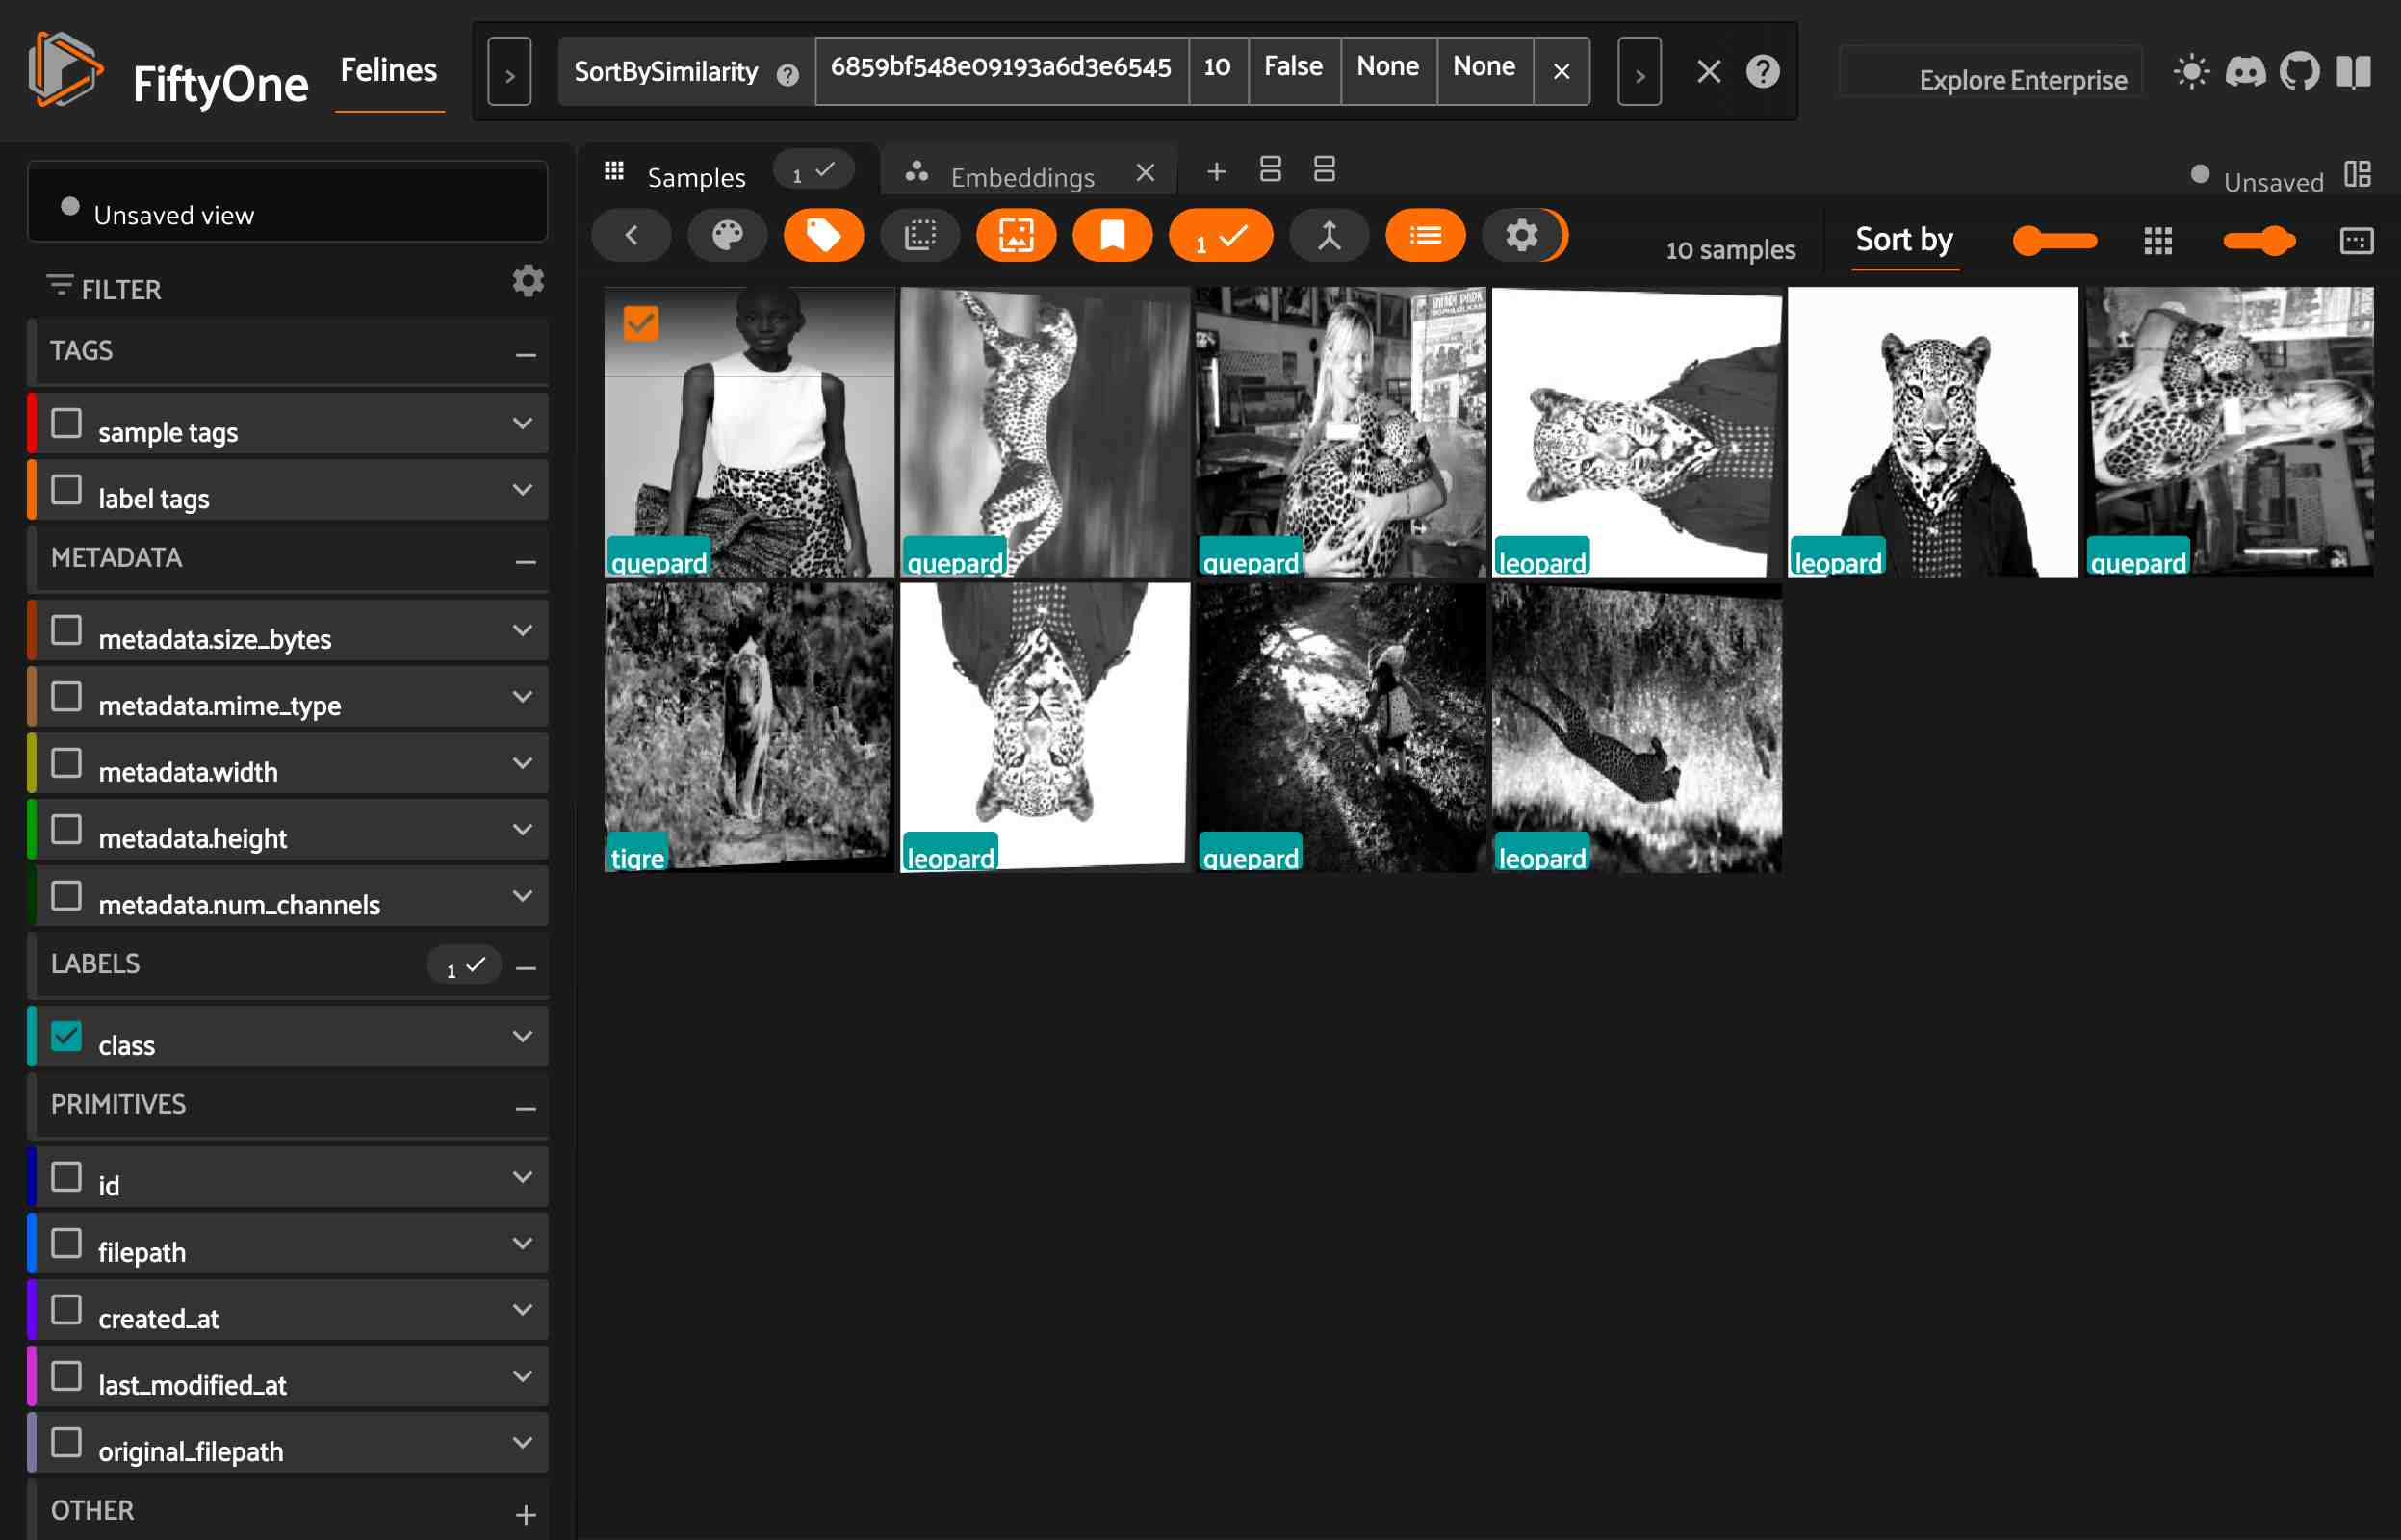

In [46]:
view = dataset.sort_by_similarity(query=outliers, k=10)
session.view = view

In [48]:
for sample in tqdm(dataset.select(outliers)):
    sample['class'] = fo.Classification(label='human')
    sample.save()

100%|██████████| 1/1 [00:00<00:00, 548.49it/s]


In [49]:
session = fo.launch_app()